In [52]:
import json
from collections import defaultdict
from transformers import AutoTokenizer
from matplotlib.ticker import FuncFormatter
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import pandas as pd
from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#44BB99', '#AAAA00',
          '#DDDDDD']
palette = sns.set_palette(COLORS)

### Load rollouts

In [5]:
START_STEP = 0
END_STEP = 90
TEST_FREQ = 15

In [6]:
folder_to_step_to_rollouts = defaultdict(lambda: dict())

for folder in ['normal', 'positive']:
    for step in range(START_STEP, END_STEP + 1, TEST_FREQ):
        rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/{folder}/{step}_rollouts.json"
        with open(rollouts_file, 'r') as f:
            folder_to_step_to_rollouts[folder][step] = json.load(f)


### Load data

In [7]:
entropy = pd.read_csv('data/entropy.csv')
reward = pd.read_csv('data/reward.csv')
extrapolation_reward = pd.read_csv('data/extrapolation_reward.csv')

### Plot graphs

/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/rliable/plot_utils.py:108: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=legendsize)
/tmp/ipykernel_1646915/3615400184.py:239: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[4].legend(
/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/rliable/plot_utils.py:108: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=legendsize)
/tmp/ipykernel_1646915/3615400184.py:279: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

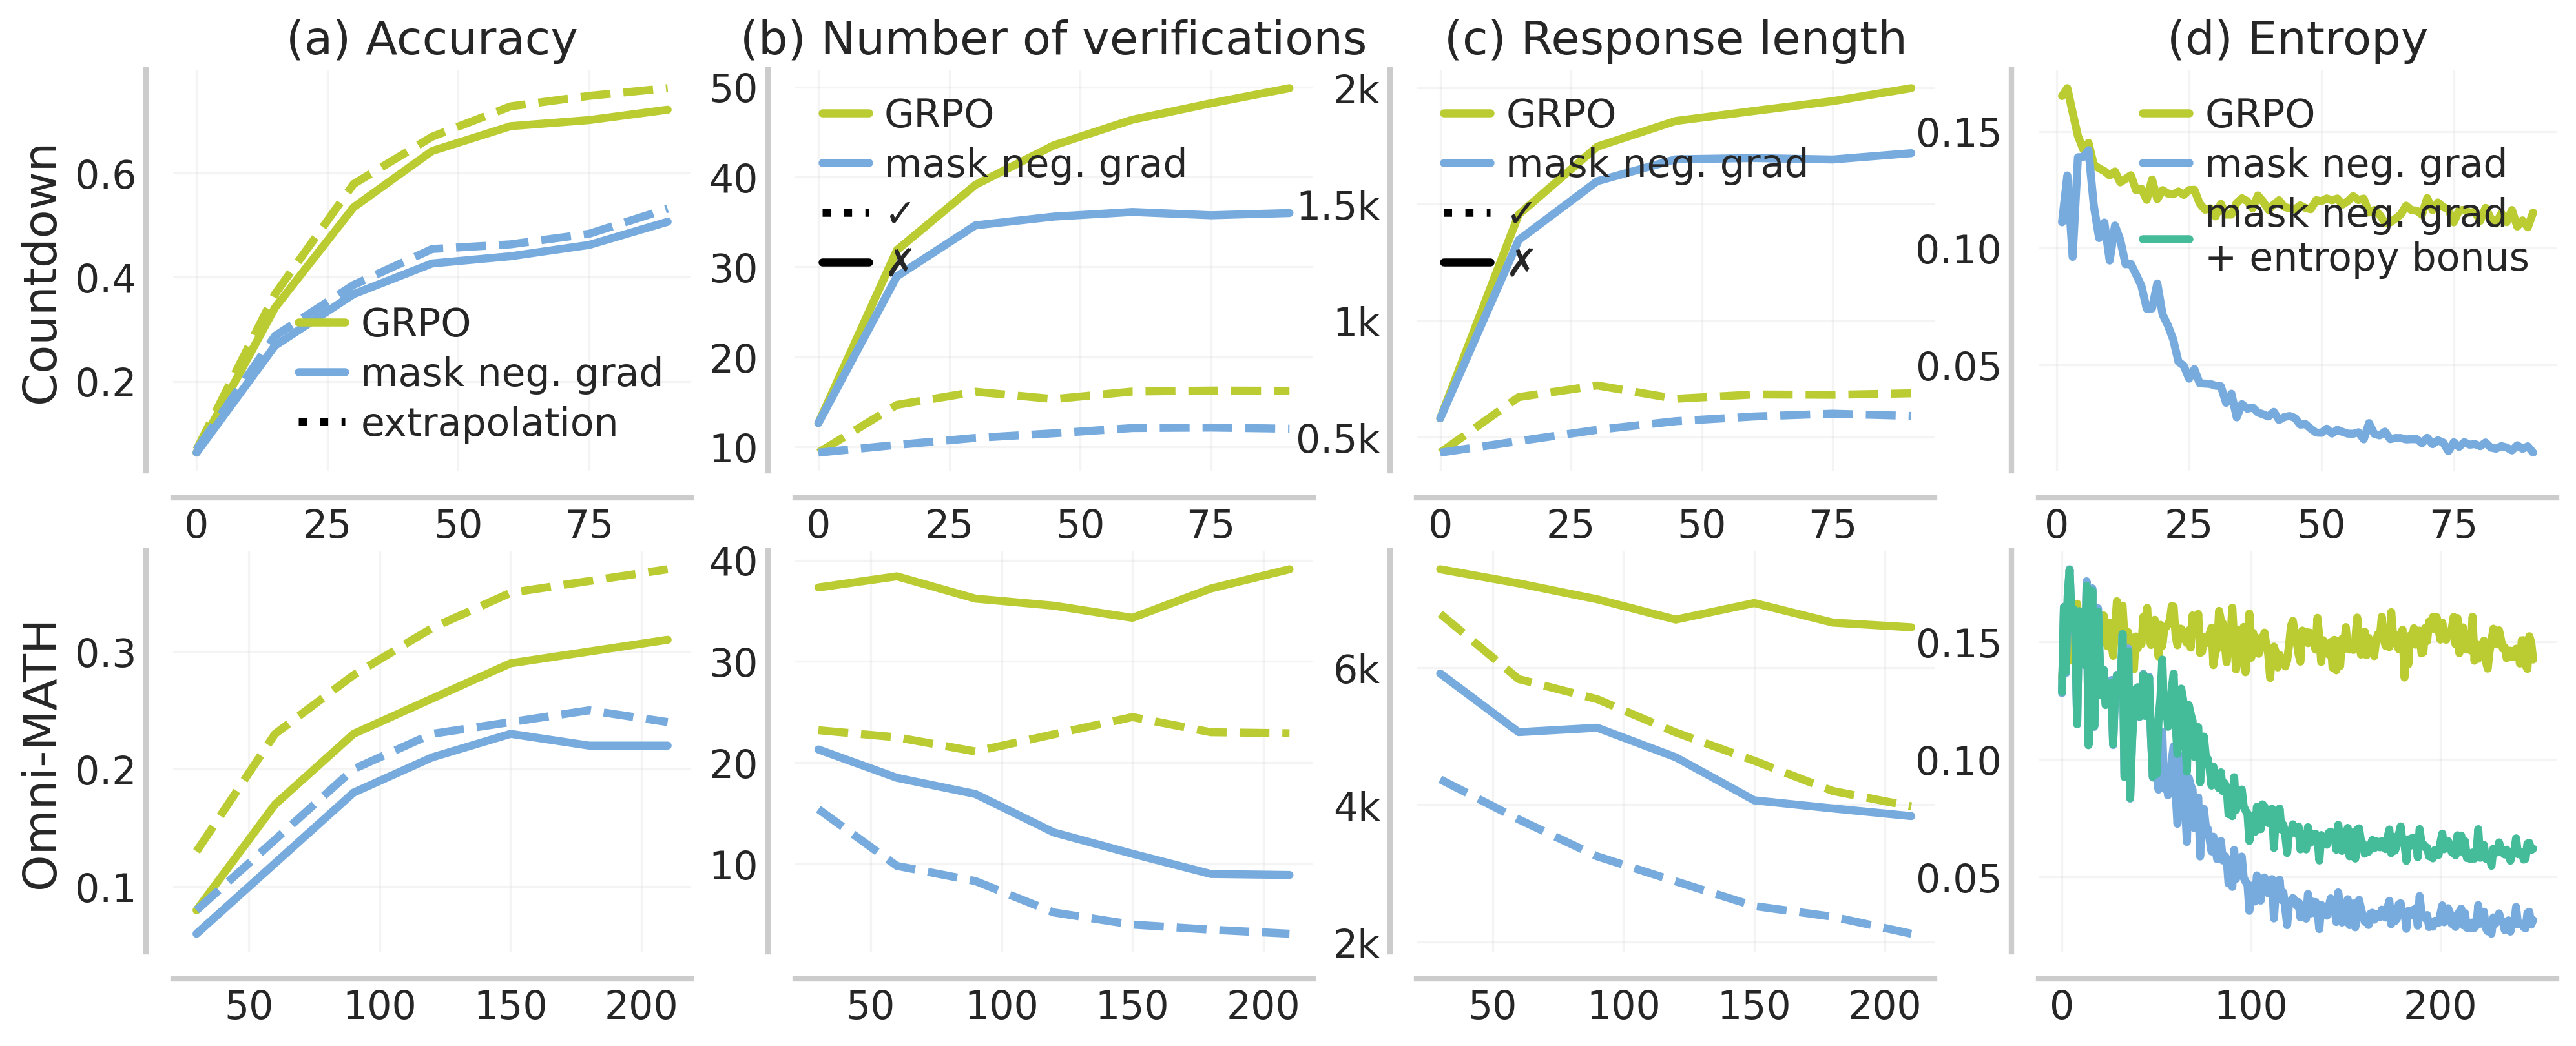

In [103]:
fig, ax = plt.subplots(nrows=2, ncols=4, dpi=300)
ax = ax.flatten()
fig.set_size_inches(496.0/250*2 * 4, 369.6/250*2*2)


# ===========================
# Accuracy
# ===========================

sns.lineplot(data=reward, x='Step', y='normal - val/reward/5', ax=ax[0], linewidth=3, markersize=8, color=COLORS[0], label=r'GRPO')
sns.lineplot(data=extrapolation_reward, x='Step', y='normal - extrapolation_val/reward/5', ax=ax[0], linewidth=3, markersize=8, color=COLORS[0], linestyle='--')

sns.lineplot(data=reward, x='Step', y='positive - val/reward/5', ax=ax[0], linewidth=3, markersize=8, color=COLORS[1], label=r'mask neg. grad')
sns.lineplot(data=extrapolation_reward, x='Step', y='positive - extrapolation_val/reward/5', ax=ax[0], linewidth=3, markersize=8, color=COLORS[1], linestyle='--')

sns.lineplot(x=[20],y=[0.4],ax=ax[0],linestyle=':',color='black', label='extrapolation', linewidth=3)

plot_utils._annotate_and_decorate_axis(ax[0],
                                        xlabel='',
                                        ylabel='Countdown',
                                        labelsize='xx-large',
                                        ticklabelsize='x-large',
                                        grid_alpha=0.2,
                                        legend=True)
                                        
ax[0].legend(
    prop={'size': 'x-large'},         # Slightly smaller font
    ncol=1,                    # Keep 1 column
    frameon=False,             # No box
    handlelength=1.2,          # Shrink line length
    handletextpad=0.4,         # Shrink space between marker and text
    borderpad=0.2,             # Shrink border padding inside legend box
    labelspacing=0.3,          # Reduce vertical space between entries
    # loc="upper left",                # Optional: auto position
    markerscale=0.8,            # Shrink marker size
    # bbox_to_anchor=(-0.1, 1)
)
ax[0].set_title('(a) Accuracy', fontsize='xx-large')


# ===========================
# Number of attempts
# ===========================

for folder in ['normal', 'positive']:
    
    lengths_0 = []
    lengths_1 = []
    
    for step in range(START_STEP, END_STEP + 1, TEST_FREQ):
        rollouts = folder_to_step_to_rollouts[folder][step]
        
        total_0_length = 0
        total_1_length = 0
        total_0 = 0
        total_1 = 0
        for rollout in rollouts:
            if rollout['ref_score'] != 5:
                continue
            if rollout['score'] == 0:
                total_0_length += len(rollout['output'].split('\n\n'))
                total_0 += 1
            elif rollout['score'] == 1:
                total_1_length += len(rollout['output'].split('\n\n'))
                total_1 += 1
        
        lengths_0.append(total_0_length / total_0)
        lengths_1.append(total_1_length / total_1)

    if folder == 'normal':
        text = r'GRPO'
    else:
        text = r'mask neg. grad'

    sns.lineplot(x=range(START_STEP, END_STEP + 1, TEST_FREQ), y=lengths_0, ax=ax[1], linewidth=3, markersize=8, color=COLORS[0] if folder == 'normal' else COLORS[1], label=f'{text}', linestyle='-')
    sns.lineplot(x=range(START_STEP, END_STEP + 1, TEST_FREQ), y=lengths_1, ax=ax[1], linewidth=3, markersize=8, color=COLORS[0] if folder == 'normal' else COLORS[1],  linestyle='--')
    if folder != 'normal':
        sns.lineplot(x=[20],y=[20],ax=ax[1],linestyle=':',color='black', label='✓', linewidth=3)
        sns.lineplot(x=[20],y=[20],ax=ax[1],linestyle='-',color='black', label='✗', linewidth=3)


plot_utils._annotate_and_decorate_axis(ax[1],
                                        # xlabel='gradient steps',
                                        # ylabel='k (# of attempts)',
                                        labelsize='xx-large',
                                        ticklabelsize='x-large',
                                        grid_alpha=0.2,
                                        legend=True)

ax[1].legend(
        prop={'size': 'x-large'},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        # loc="upper left",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

ax[1].set_title('(b) Number of verifications', fontsize='xx-large')


# ===========================
# Response length
# ===========================

for folder in ['normal', 'positive']:
    
    lengths_0 = []
    lengths_1 = []
    
    for step in range(START_STEP, END_STEP + 1, TEST_FREQ):
        rollouts = folder_to_step_to_rollouts[folder][step]
        
        total_0_length = 0
        total_1_length = 0
        total_0 = 0
        total_1 = 0
        for rollout in rollouts:
            if rollout['ref_score'] != 5:
                continue
            if rollout['score'] == 0:
                total_0_length += rollout['length']
                total_0 += 1
            elif rollout['score'] == 1:
                total_1_length += rollout['length']
                total_1 += 1
        
        lengths_0.append(total_0_length / total_0)
        lengths_1.append(total_1_length / total_1)
    
    if folder == 'normal':
        text = r'GRPO'
    else:
        text = r'mask neg. grad'

    sns.lineplot(x=range(START_STEP, END_STEP + 1, TEST_FREQ), y=lengths_0, ax=ax[2], linewidth=3, markersize=8, color=COLORS[0] if folder == 'normal' else COLORS[1], label=f'{text}', linestyle='-')
    sns.lineplot(x=range(START_STEP, END_STEP + 1, TEST_FREQ), y=lengths_1, ax=ax[2], linewidth=3, markersize=8, color=COLORS[0] if folder == 'normal' else COLORS[1],  linestyle='--')
    if folder != 'normal':
        sns.lineplot(x=[20],y=[1000],ax=ax[2],linestyle=':',color='black', label='✓', linewidth=3)
        sns.lineplot(x=[20],y=[1000],ax=ax[2],linestyle='-',color='black', label='✗', linewidth=3)

plot_utils._annotate_and_decorate_axis(ax[2],
                                        # xlabel='gradient steps',
                                        # ylabel='length (tokens)',
                                        labelsize='xx-large',
                                        ticklabelsize='x-large',
                                        grid_alpha=0.2,
                                        legend=True)

ax[2].legend(
        prop={'size': 'x-large'},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        loc="upper left",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

def k_formatter(x, pos):
    if x % 1000 == 0:
        return f'{int(x/1000)}k'
    else:
        return f'{x/1000:.1f}k'

# Set formatter for y-axis
ax[2].yaxis.set_major_formatter(FuncFormatter(k_formatter))
ax[2].set_title('(c) Response length', fontsize='xx-large')


# ===========================
# Entropy
# ===========================

sns.lineplot(data=entropy, x='Step', y='normal - actor/entropy', ax=ax[3], linewidth=3, markersize=8, color=COLORS[0], label=r'GRPO')
sns.lineplot(data=entropy, x='Step', y='positive - actor/entropy', ax=ax[3], linewidth=3, markersize=8, color=COLORS[1], label=r'mask neg. grad')
sns.lineplot(x=[20],y=[0.1],ax=ax[3],color=COLORS[2], label='mask neg. grad\n+ entropy bonus', linewidth=3)

plot_utils._annotate_and_decorate_axis(ax[3],
                                        # xlabel='gradient steps',
                                        # ylabel='entropy',
                                        labelsize='xx-large',
                                        ticklabelsize='x-large',
                                        grid_alpha=0.2,
                                        legend=True)

ax[3].legend(
        prop={'size': 'x-large'},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        loc="upper right",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

ax[3].set_title('(d) Entropy', fontsize='xx-large')



# ===========================
# Math, accuracy
# ===========================

btr = {
    'stdGRPO':   [0.08, 0.17, 0.23, 0.26, 0.29, 0.30, 0.31],
    'maskedneg': [0.06, 0.12, 0.18, 0.21, 0.23, 0.22, 0.22]
}
bex = {
    'stdGRPO':   [0.13, 0.23, 0.28, 0.32, 0.35, 0.36, 0.37],
    'maskedneg': [0.08, 0.14, 0.20, 0.23, 0.24, 0.25, 0.24]
}


sns.lineplot(x=np.arange(30, 211, 30), y=btr['stdGRPO'], ax=ax[4], linewidth=3, markersize=8, color=COLORS[0])
sns.lineplot(x=np.arange(30, 211, 30), y=bex['stdGRPO'], ax=ax[4], linewidth=3, markersize=8, color=COLORS[0], linestyle='--')

sns.lineplot(x=np.arange(30, 211, 30), y=btr['maskedneg'], ax=ax[4], linewidth=3, markersize=8, color=COLORS[1])
sns.lineplot(x=np.arange(30, 211, 30), y=bex['maskedneg'], ax=ax[4], linewidth=3, markersize=8, color=COLORS[1], linestyle='--')

plot_utils._annotate_and_decorate_axis(ax[4],
                                        xlabel='',
                                        ylabel='Omni-MATH',
                                        labelsize='xx-large',
                                        ticklabelsize='x-large',
                                        grid_alpha=0.2,
                                        legend=True)
                                        
ax[4].legend(
    prop={'size': 'x-large'},         # Slightly smaller font
    ncol=1,                    # Keep 1 column
    frameon=False,             # No box
    handlelength=1.2,          # Shrink line length
    handletextpad=0.4,         # Shrink space between marker and text
    borderpad=0.2,             # Shrink border padding inside legend box
    labelspacing=0.3,          # Reduce vertical space between entries
    # loc="upper left",                # Optional: auto position
    markerscale=0.8,            # Shrink marker size
    # bbox_to_anchor=(-0.1, 1)
)

# ===========================
# Math, number of attempts
# ===========================
vers_0 = {
    'stdGRPO':   [37.3, 38.4, 36.2, 35.5, 34.3, 37.2, 39.1],
    'maskedneg': [21.3, 18.5, 16.9, 13.1, 11.0, 9.0, 8.9]
}

vers_1 = {
    'stdGRPO':   [23.2, 22.5, 21.1, 22.8, 24.5, 23.0, 22.9],
    'maskedneg': [15.4, 9.8, 8.3, 5.2, 4.0, 3.5, 3.1]
}

sns.lineplot(x=np.arange(30, 211, 30), y=vers_0['stdGRPO'], ax=ax[5], linewidth=3, markersize=8, color=COLORS[0], linestyle='-')
sns.lineplot(x=np.arange(30, 211, 30), y=vers_1['stdGRPO'], ax=ax[5], linewidth=3, markersize=8, color=COLORS[0],  linestyle='--')

sns.lineplot(x=np.arange(30, 211, 30), y=vers_0['maskedneg'], ax=ax[5], linewidth=3, markersize=8, color=COLORS[1], linestyle='-')
sns.lineplot(x=np.arange(30, 211, 30), y=vers_1['maskedneg'], ax=ax[5], linewidth=3, markersize=8, color=COLORS[1],  linestyle='--')

plot_utils._annotate_and_decorate_axis(ax[5],
                                        # xlabel='gradient steps',
                                        # ylabel='k (# of attempts)',
                                        labelsize='xx-large',
                                        ticklabelsize='x-large',
                                        grid_alpha=0.2,
                                        legend=True)

ax[5].legend(
        prop={'size': 'x-large'},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        loc="upper left",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )



# ===========================
# Math, response length
# ===========================
lengths_0 = {
    'stdGRPO':   [7435, 7229, 6997, 6701, 6942, 6657, 6588],
    'maskedneg': [5915, 5059, 5124, 4693, 4065, 3947, 3835]
}

lengths_1 = {
    'stdGRPO':   [6786, 5833, 5540, 5055, 4642, 4201, 3977],
    'maskedneg': [4371, 3787, 3248, 2883, 2524, 2368, 2120]
}


sns.lineplot(x=np.arange(30, 211, 30), y=lengths_0['stdGRPO'], ax=ax[6], linewidth=3, markersize=8, color=COLORS[0], linestyle='-')
sns.lineplot(x=np.arange(30, 211, 30), y=lengths_1['stdGRPO'], ax=ax[6], linewidth=3, markersize=8, color=COLORS[0], linestyle='--')

sns.lineplot(x=np.arange(30, 211, 30), y=lengths_0['maskedneg'], ax=ax[6], linewidth=3, markersize=8, color=COLORS[1], linestyle='-')
sns.lineplot(x=np.arange(30, 211, 30), y=lengths_1['maskedneg'], ax=ax[6], linewidth=3, markersize=8, color=COLORS[1], linestyle='--')

plot_utils._annotate_and_decorate_axis(ax[6],
                                        # xlabel='gradient steps',
                                        # ylabel='k (# of attempts)',
                                        labelsize='xx-large',
                                        ticklabelsize='x-large',
                                        grid_alpha=0.2,
                                        legend=True)

ax[6].legend(
        prop={'size': 'x-large'},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        loc="upper left",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

ax[6].yaxis.set_major_formatter(FuncFormatter(k_formatter))

# ===========================
# Math, entropy
# ===========================

neg_grad = [0.1346843041041318,
 0.1444744323690732,
 0.145392570644617,
 0.1601693078875541,
 0.1419875519840341,
 0.1638410546713405,
 0.1503990020602941,
 0.1615792229771614,
 0.1662479043006897,
 0.1504603789040917,
 0.1530820626765489,
 0.1581553492695093,
 0.1401737499095144,
 0.1500679044560952,
 0.1546903315931558,
 0.1630027379840612,
 0.1616953433979125,
 0.1538332063704729,
 0.160626545548439,
 0.1488994720081488,
 0.159704351354213,
 0.1571768890652391,
 0.1612625125795602,
 0.1575110142952517,
 0.1481315826899127,
 0.1582363525574857,
 0.1499592122577485,
 0.1440380558371544,
 0.1558053687214851,
 0.1673235788941383,
 0.1546203657984733,
 0.1616848055273294,
 0.1654375878473123,
 0.152058998743693,
 0.1509387716650962,
 0.1541572115384042,
 0.1480641759493771,
 0.1471792153186268,
 0.1383251056951635,
 0.1523013032580676,
 0.1471598152485158,
 0.1513283364474773,
 0.1490446151130729,
 0.1607524147805045,
 0.1593139075181063,
 0.1644652854455144,
 0.1517538415158496,
 0.1486818653841813,
 0.1494033398727575,
 0.1594237479216912,
 0.1567291758126682,
 0.1437956263360224,
 0.1572599622110525,
 0.1482404794543981,
 0.1552545894917688,
 0.1562677692208025,
 0.1574403792619705,
 0.1592183953358067,
 0.1652904780287491,
 0.1650428225596746,
 0.1529362669421566,
 0.1485698140765491,
 0.1556524528484595,
 0.1555784630278746,
 0.1513705186937984,
 0.1509850352174706,
 0.1494820141478588,
 0.1549645552509709,
 0.1475414973166254,
 0.161274694298443,
 0.1540575118528472,
 0.1541010605938294,
 0.1618897348642349,
 0.1452783824581849,
 0.1458064647097336,
 0.1522133078645257,
 0.1494842573172516,
 0.1496317865032898,
 0.1534659050797161,
 0.1559586494284517,
 0.1400944397729986,
 0.1457311483590226,
 0.1471314107378324,
 0.1632195130774849,
 0.1591403272591139,
 0.1579049689074357,
 0.1491769543952412,
 0.1412960683044634,
 0.1503356146185021,
 0.1513367659515804,
 0.1645660404529836,
 0.1501123681664466,
 0.1382258989744716,
 0.1428280617627832,
 0.1551680804954635,
 0.1499845328576424,
 0.1563530923689113,
 0.1370661271115144,
 0.1495243296027183,
 0.1620409223768446,
 0.1432148545152611,
 0.1539106149883831,
 0.14818578834335,
 0.1489340058631367,
 0.1449250131845474,
 0.1517752422129406,
 0.1509854228180997,
 0.1539413415723377,
 0.1485647625393337,
 0.1447022046893835,
 0.1346169917119873,
 0.1461001305203688,
 0.1479740850627422,
 0.1456356026670512,
 0.1391391863717752,
 0.1444924516897452,
 0.1424019630340968,
 0.1417208046597593,
 0.139557256902519,
 0.142098085845218,
 0.1486107077863481,
 0.1568357975859391,
 0.1589129480222861,
 0.1541373054496944,
 0.1501888851909076,
 0.1448293721510304,
 0.1415768091877301,
 0.1548261770771609,
 0.1503466636770301,
 0.1543276016083028,
 0.1494592742787467,
 0.1539648245362674,
 0.1495608112050427,
 0.1511999000277784,
 0.1467046122017659,
 0.1602447060377974,
 0.1517488150035633,
 0.1414520157610669,
 0.1507374675650345,
 0.1461221451560656,
 0.1451634668252047,
 0.1446152035560872,
 0.1499608432253202,
 0.138984042737219,
 0.1508746739062998,
 0.1379027252688127,
 0.1419959795825621,
 0.1396986018208896,
 0.1512409138182799,
 0.1468458231538534,
 0.1562890910050448,
 0.1472631506621837,
 0.1467358416153324,
 0.1483709472748968,
 0.1465512983062688,
 0.1511221135917463,
 0.1603492042049765,
 0.1507033898549921,
 0.1446027281252961,
 0.1515158654914962,
 0.154349148273468,
 0.144288000307585,
 0.1516917580738663,
 0.1460985203876215,
 0.1484410733812385,
 0.1439466066658496,
 0.1505461396539912,
 0.1533973493120249,
 0.1518802564177248,
 0.1607262375764548,
 0.1511903901894887,
 0.1482981760054826,
 0.1499208187063535,
 0.147740611258675,
 0.1626624738176663,
 0.1529882690485786,
 0.1531296020580662,
 0.1488516243065104,
 0.1468724297980467,
 0.1529929900870603,
 0.1552140228450298,
 0.13481355458498,
 0.1461886335164308,
 0.1403964054770767,
 0.1526986476447847,
 0.1512713621060053,
 0.1558101307600736,
 0.1488102575143178,
 0.1504471438626448,
 0.1547980527667438,
 0.1450784890912473,
 0.1455757298013743,
 0.1559675716691547,
 0.1503432736628585,
 0.1586457920425078,
 0.1558942054708798,
 0.1606192075543933,
 0.1553243808448314,
 0.1605937508866191,
 0.1553354501724243,
 0.1509491149336099,
 0.1582424202933907,
 0.1516056779552908,
 0.1508895042352378,
 0.1529168460298987,
 0.1540393740870058,
 0.1556645059026777,
 0.160610861638013,
 0.1489180979483267,
 0.1601432412862777,
 0.1451905503869056,
 0.1490490374465783,
 0.1561684551484444,
 0.1518964665010571,
 0.1467006973483983,
 0.1476292237639427,
 0.1463302145712077,
 0.1607126848478066,
 0.1419887486845255,
 0.149262105114758,
 0.1428166735503408,
 0.1469856789335608,
 0.1491536081713788,
 0.1505627473816275,
 0.1417522960238986,
 0.1386112303418271,
 0.1460751466014806,
 0.1507008532062173,
 0.1556105361216598,
 0.1501393529276053,
 0.1489532673183609,
 0.1549358053339852,
 0.1509821967167013,
 0.1471625338582431,
 0.1477728285826742,
 0.1430873977951705,
 0.1445895227439263,
 0.1462527206167578,
 0.1434947357458227,
 0.143850077688694,
 0.1471009022172759,
 0.1466149626409306,
 0.1407721708802616,
 0.1506772396319052,
 0.1507075424823496,
 0.1400061165913939,
 0.1384377046488225,
 0.1523856161271824,
 0.1497806566767394,
 0.1424875276930192]



pos_grad = [0.1281738703449567,
 0.1649319349477688,
 0.136622209911761,
 0.1680920888548312,
 0.1809289093528475,
 0.1604378148913383,
 0.1623984297568148,
 0.1521466465836221,
 0.1153559722006321,
 0.1625651398842985,
 0.1524721371630827,
 0.1511363190683451,
 0.1401740498840809,
 0.1758225231120983,
 0.1077299676835537,
 0.1364017299686869,
 0.172799549686412,
 0.1138090131723362,
 0.1483141634274613,
 0.1642992996743747,
 0.1394081694835966,
 0.1273633738358815,
 0.1381329067728736,
 0.1245353175770668,
 0.1266800140341123,
 0.1318721361458301,
 0.1337536115731512,
 0.1060564209791747,
 0.128437058911437,
 0.1360089938555445,
 0.1323107761286553,
 0.1305439663322075,
 0.1534086652100086,
 0.0934839539229869,
 0.0977198548614978,
 0.1471894018352031,
 0.0832914907485246,
 0.1089322682470083,
 0.1246484216302633,
 0.1297721009362827,
 0.1299433665055977,
 0.1180584769695997,
 0.1259491804987192,
 0.1364004790782928,
 0.1199235920059053,
 0.1223439410328865,
 0.1351713949912472,
 0.1097455848204462,
 0.0922429226338863,
 0.0991491273873382,
 0.0934624224901199,
 0.0871078439056873,
 0.0965445397628678,
 0.1118470489194518,
 0.0874823730438947,
 0.0935816567391157,
 0.0846905455385383,
 0.0880788683891296,
 0.0996273080153124,
 0.1055498754507617,
 0.0864973868194379,
 0.0725200563669204,
 0.0859116170751421,
 0.1012959633218614,
 0.0947487915032788,
 0.08046153540674,
 0.0648200231555261,
 0.092116394597623,
 0.0889739455545649,
 0.0870084691988794,
 0.0706563629209995,
 0.0822041150596406,
 0.0837659450247883,
 0.0586350734035174,
 0.0773945619401178,
 0.0788706936356094,
 0.0712295998301771,
 0.0705459146863884,
 0.0658800435416838,
 0.0608000913087059,
 0.0670622123612297,
 0.0623117159855993,
 0.0574897310059321,
 0.0581716794520616,
 0.0652589767294771,
 0.05693260010551,
 0.0589327071519459,
 0.0578280172365553,
 0.0471629259225569,
 0.0522804970128668,
 0.045686865846316,
 0.0614327388919062,
 0.0491350102973611,
 0.0570339877158403,
 0.0556613360531628,
 0.0585979821489137,
 0.0496607967134979,
 0.0478960301946191,
 0.0470659460872411,
 0.0355058070272207,
 0.0428500515926215,
 0.0463648445027716,
 0.0394787669770027,
 0.0505852026536184,
 0.0447572349674171,
 0.0398629870923126,
 0.0489539454745895,
 0.0497123125112719,
 0.0459499033167958,
 0.0429318042472004,
 0.045704752827684,
 0.048995210064782,
 0.0322529221639821,
 0.0436305625035482,
 0.0405424759956076,
 0.0487685906974708,
 0.0401020295685157,
 0.0432975403964519,
 0.0364753176507196,
 0.0293931575382457,
 0.0385415785713121,
 0.0396438550792242,
 0.0409468485809424,
 0.0400841098744422,
 0.0377465301426127,
 0.0392139516770839,
 0.0326600469416007,
 0.0370900783454999,
 0.037789262831211,
 0.0321689651658137,
 0.0426410828881404,
 0.0342875083287557,
 0.0395063903182745,
 0.0345450155436992,
 0.0392519341891302,
 0.0355257312249806,
 0.0277231163034836,
 0.0380788478342925,
 0.0347199856358415,
 0.0359770221402868,
 0.0334288949379697,
 0.0374186715343967,
 0.0408168107490329,
 0.0378631265724406,
 0.0362553993472829,
 0.0307478783652186,
 0.0433364945153395,
 0.0369455896317958,
 0.0305066963329034,
 0.0344524555839598,
 0.0309860241909821,
 0.0404478904092684,
 0.0293963126605376,
 0.0331548501271754,
 0.0386199846398085,
 0.0284742074196829,
 0.0381909824375595,
 0.0401518171032269,
 0.0365204636884086,
 0.0335616612574085,
 0.0308022268582135,
 0.0309676295767227,
 0.029461852624081,
 0.034306819550693,
 0.0346823270665481,
 0.0316999449084202,
 0.0342887892620638,
 0.0329381513098875,
 0.0327892911565654,
 0.0360106905301411,
 0.0343589813758929,
 0.0326024540034788,
 0.0366065171547234,
 0.0397805047354527,
 0.0298196092480793,
 0.0361599591871102,
 0.0311009218916296,
 0.0321397976328929,
 0.0383401720318943,
 0.0387149176427296,
 0.0340948330859343,
 0.034760936970512,
 0.0278319541364908,
 0.0354687912123543,
 0.0333817162861426,
 0.0357734096857408,
 0.0352381871392329,
 0.0366903985540072,
 0.0291824991504351,
 0.0418076328933239,
 0.0347652411354439,
 0.0329581407297934,
 0.0322136760999759,
 0.0336948122297014,
 0.0285800586986754,
 0.0293352333112404,
 0.0287330363644287,
 0.0312362149124965,
 0.0306812496139453,
 0.0303963805947984,
 0.0342061486361282,
 0.0378140381404331,
 0.0306435652515467,
 0.0331462287743176,
 0.0366183135192841,
 0.0346745131537318,
 0.0299248628850494,
 0.0297983884811401,
 0.0286284626772006,
 0.0338166235635678,
 0.0350456067289297,
 0.0364136909445126,
 0.0293626557769519,
 0.0345338344840066,
 0.0282523414740959,
 0.0280401398194953,
 0.0282320225877421,
 0.0305558241903781,
 0.0282165430752294,
 0.0293192756362259,
 0.0379483774304389,
 0.029965109457927,
 0.0313432006431477,
 0.035144823603332,
 0.0281330203016599,
 0.0267803444025608,
 0.0282758159030761,
 0.0257488582283258,
 0.0327191434800624,
 0.0299481324618682,
 0.0310989542465124,
 0.0344160445034503,
 0.0316011336232934,
 0.030806611602505,
 0.0273223426192998,
 0.0309045427877988,
 0.0314535111188888,
 0.0266654454171657,
 0.0302872080355882,
 0.0300347132142633,
 0.0371423009783029,
 0.0297284182161092,
 0.0300019859121396,
 0.0297380801556365,
 0.0285125363618135,
 0.0279943911979595,
 0.0345930743675965,
 0.03511695603707,
 0.0296056933168854,
 0.0315454200220604]


pos_grad_ent = [0.12867058449796792,
 0.1647936706465976,
 0.13726989844986168,
 0.16961511871123924,
 0.18069475597812418,
 0.1602036779343891,
 0.16397764257232217,
 0.152914081312775,
 0.11488649781469715,
 0.16310769992788446,
 0.15200871947027023,
 0.15067058931477484,
 0.14041601215564692,
 0.1739092428674405,
 0.10600504985104066,
 0.13583944243944593,
 0.17178671856607758,
 0.11412326050493148,
 0.14740613935194008,
 0.1628869959730394,
 0.14087381825251816,
 0.12713759753539497,
 0.13820043497756151,
 0.12311056939085335,
 0.12613563130958713,
 0.13198305873553998,
 0.1326026179957289,
 0.10643211899752036,
 0.1278364202215182,
 0.13571730010575123,
 0.13170906951642591,
 0.13239624451671644,
 0.15339516798527067,
 0.092426242994031,
 0.09854239977360099,
 0.14596855818523208,
 0.08350035434352936,
 0.10697259812312852,
 0.12332023558136486,
 0.12996896217215181,
 0.1306818330855931,
 0.11822984525078967,
 0.12583353221633095,
 0.13609937538270353,
 0.11844507001553788,
 0.12162409682449178,
 0.13471075622028741,
 0.11080270704666512,
 0.09258654092345475,
 0.09738608723197548,
 0.0937865064595147,
 0.11672276162527098,
 0.12586761776256183,
 0.14245872520829267,
 0.11851337256639065,
 0.12451293685823189,
 0.11385132801531567,
 0.11776965601327838,
 0.12995857144671596,
 0.13652542057788405,
 0.11601821258159262,
 0.10233439739025657,
 0.11480528210113607,
 0.13009975669778073,
 0.125561317325673,
 0.11181777543531082,
 0.09474801303394575,
 0.12311992749551502,
 0.11933558157961253,
 0.11636334944427427,
 0.1010177585265079,
 0.11374215162610657,
 0.11373011898567835,
 0.09019971705933141,
 0.10477481683602806,
 0.10969259613998462,
 0.10131664689841527,
 0.10024690733592254,
 0.09597180431821929,
 0.088812522394105,
 0.09684254047339218,
 0.09266882855711105,
 0.08896762505067361,
 0.08765340923378795,
 0.09445048312658391,
 0.08643084306192547,
 0.08984810926964798,
 0.08815676834621498,
 0.07663316571878986,
 0.08279376444598016,
 0.07578394339566404,
 0.0924013838824391,
 0.07843295720348376,
 0.08670632556924253,
 0.08526922790003064,
 0.08713446720078158,
 0.07995691699056248,
 0.07815708546679899,
 0.07707105954388356,
 0.06527121989384554,
 0.07143468085057109,
 0.07594419918000624,
 0.06913605246047592,
 0.07978292538439678,
 0.07459594925575108,
 0.07026703794912714,
 0.08084013137580003,
 0.07988689032410373,
 0.07620745370751857,
 0.07285735833143424,
 0.07378598161238495,
 0.07896869618933278,
 0.062313152373923125,
 0.07609380461603349,
 0.07035011503082647,
 0.07907013803980441,
 0.07006731779881045,
 0.07212886235883237,
 0.06761814046523462,
 0.06014509057093247,
 0.06933261051835515,
 0.06873446762442946,
 0.07234964289187851,
 0.06868225881164991,
 0.06833338723641297,
 0.07140440730289388,
 0.06166951061647001,
 0.06652378061589713,
 0.06788891419629864,
 0.061665489511697494,
 0.07109041945707427,
 0.06435607130356172,
 0.0684440866045484,
 0.06501860797433438,
 0.0683325099548964,
 0.06707566562999814,
 0.05693986301114736,
 0.06775678631808682,
 0.06553350285321116,
 0.06474615782385285,
 0.06365635487257383,
 0.06872581428867913,
 0.06920932751447167,
 0.06804776043097291,
 0.06651528214153132,
 0.061529701236995915,
 0.07209954380446142,
 0.06562513301871152,
 0.061028637898520297,
 0.06474944025719298,
 0.06123651704132797,
 0.07079433861876537,
 0.05871628793895911,
 0.0633871038243364,
 0.06891305711310718,
 0.057759856001656534,
 0.07005675694870425,
 0.07062565002413869,
 0.06532916019120595,
 0.06421821486604232,
 0.05982754518798618,
 0.06175471418046515,
 0.0606204482030884,
 0.06348613723234128,
 0.06564570319579242,
 0.062112725835356694,
 0.06511084942205829,
 0.06483494429254144,
 0.06254390304056252,
 0.0652569543657836,
 0.06346946694626737,
 0.06178664371851336,
 0.0665294154453093,
 0.07012165671026935,
 0.06009630004740932,
 0.06698714243614623,
 0.06111392378350751,
 0.06359333171005022,
 0.06807551519865634,
 0.07143508680931922,
 0.06472050043369931,
 0.06390377941409572,
 0.056761061638429686,
 0.06595126362759748,
 0.06315825350081675,
 0.0664874101798329,
 0.06571142476380644,
 0.06661756964135032,
 0.05833570543236669,
 0.07029278566863803,
 0.06431872618337688,
 0.06381453952411688,
 0.0624277698441061,
 0.06244907345098941,
 0.05875323962452658,
 0.05972055069096924,
 0.057849178928227565,
 0.06138994001844203,
 0.060739458332391305,
 0.059253410296967776,
 0.06456393599647647,
 0.06837482266680134,
 0.06172661649472198,
 0.0642000308263525,
 0.065240644151327,
 0.06373668811381668,
 0.06043989815225806,
 0.06031217443205231,
 0.05914351036350665,
 0.06766935505422253,
 0.06561649723962287,
 0.0675492565846932,
 0.0603166575404451,
 0.0651852257353124,
 0.05793707222945556,
 0.05879910903998857,
 0.057459197373204526,
 0.06031900558363809,
 0.0577311795274003,
 0.05940114977561222,
 0.07026303599711241,
 0.05809784426533525,
 0.06202946083352222,
 0.06353210773214235,
 0.057661088435870464,
 0.05786929499952817,
 0.058340095922171556,
 0.05467111345039649,
 0.06200383977080243,
 0.06062773021080287,
 0.06036858761479526,
 0.06463250309303228,
 0.06164670546319721,
 0.06015501125489918,
 0.059466286708625124,
 0.06153846181011681,
 0.059428368532231185,
 0.05685189973193513,
 0.059625421570819806,
 0.06088714654905952,
 0.0663497802398702,
 0.059613681774642296,
 0.060506973191120056,
 0.06060383534980662,
 0.057312239954757725,
 0.05765988996211855,
 0.06411812905643555,
 0.06446362680449629,
 0.061371147557166494,
 0.061950401733021354]

sns.lineplot(x=np.arange(0, 250), y=neg_grad, ax=ax[7], linewidth=3, markersize=8, color=COLORS[0])
sns.lineplot(x=np.arange(0, 250), y=pos_grad, ax=ax[7], linewidth=3, markersize=8, color=COLORS[1])
sns.lineplot(x=np.arange(0, 250), y=pos_grad_ent, ax=ax[7], linewidth=3, markersize=8, color=COLORS[2])

plot_utils._annotate_and_decorate_axis(ax[7],
                                        # xlabel='gradient steps',
                                        # ylabel='entropy',
                                        labelsize='xx-large',
                                        ticklabelsize='x-large',
                                        grid_alpha=0.2,
                                        legend=True)

ax[7].legend(
        prop={'size': 'x-large'},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        # loc="upper right",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

plt.savefig("plots/ng_all.pdf", bbox_inches='tight',pad_inches=0)
plt.show()